In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import json
import cv2 as cv
from tqdm import tqdm

def IOU(a, b):
    assert a.shape == b.shape and len(a.shape) == 2
    return np.count_nonzero(np.logical_and(a, b)) / np.count_nonzero(np.logical_or(a, b))


In [2]:
# VOC labels
label_colors= np.asarray(
        [
            [0, 0, 0],
            [128, 0, 0],
            [0, 128, 0],
            [128, 128, 0],
            [0, 0, 128],
            [128, 0, 128],
            [0, 128, 128],
            [128, 128, 128],
            [64, 0, 0],
            [192, 0, 0],
            [64, 128, 0],
            [192, 128, 0],
            [64, 0, 128],
            [192, 0, 128],
            [64, 128, 128],
            [192, 128, 128],
            [0, 64, 0],
            [128, 64, 0],
            [0, 192, 0],
            [128, 192, 0],
            [0, 64, 128],
        ]
    ).astype(np.uint8)

label_texts = [
    'background',
    'aeroplane', 
    'bicycle', 
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'potted plant',
    'sheep',
    'sofa',
    'train',
    'tv/monitor'
]

In [3]:
if False:
    pred = '/nfs/ws1/ryan/CleanCode/Projects/Peekaboo/Experiments/Dreams/untracked/for_xiang/ref_voc'
    prefix = '/nfs/ws1/datasets/RefVOC/'
    gt = '/raid/datasets/pascal_voc/VOC2012/SegmentationClass'

    from IPython.display import display
    from PIL import Image

    def zip_to_single_channel(l):
        return (l[...,0] // 4)  + (l[...,1] // 16) + l[...,2] // 64

    zipped_labels = zip_to_single_channel(label_colors).tolist()
    print(zipped_labels)

    def eval_peekaboo_voc(prefix, pred, gt):
        unfinished = []
        with open(os.path.join(prefix, 'cropped.txt'), 'r') as f:
            names = f.readlines()

        # random.shuffle(names)

        res = []

        folders = glob(f'{pred}/*')
        methods = [folder.split('/')[-1] for folder in folders]

        for name in tqdm(names):
            words = name.split()
            image_name = words[0]
            cls_name = ' '.join(words[1:])

            with open(f'{prefix}/cropped-{image_name}.jpg.txt', 'r') as f:
                x1, x2, y1, y2 = f.readline().split()
                x1 = int(x1)
                x2 = int(x2)
                y1 = int(y1)
                y2 = int(y2)



                gt_img = cv.imread(os.path.join(gt, f'{image_name}.png'))[y1:y2, x1:x2, ::-1]
                gt_img = zip_to_single_channel(gt_img)
                h, w = gt_img.shape
                cls_idx = label_texts.index(cls_name)
                cls_color = zipped_labels[cls_idx]

                mapb = gt_img == cls_color

                for method, folder in zip(methods, folders):
                    if method == 'preview_images':
                        continue
                    image_target = os.path.join(folder, f'alpha', f'cropped-{image_name}.jpg')
                    if not os.path.exists(image_target):
                        unfinished.append(image_target)
                        continue
                    pred_img = cv.resize(cv.imread(image_target, 0), (w, h), cv.INTER_NEAREST)

                    for t in range(10):
                        thre = t * 255 / 10
                        mapa = pred_img > thre

                        # print(mapa.shape, mapb.shape)
                        iou = IOU(mapa, mapb)
                        """
                        # debug
                        print(image_name, cls_name, iou)
                        display(Image.fromarray(mapa))
                        display(Image.fromarray(mapb))
                        break
                        """
                        res.append((iou, cls_name, f'Peekaboo-{method}', thre))
        print("Unfinished images:")
        print(unfinished)
        return pd.DataFrame(data=res, columns=['IoU', 'class', 'method', 'threshold']), unfinished
    gp1, unfinished1 = eval_peekaboo_voc(prefix, pred, gt)

gp1

gp1.groupby(['method', 'class', 'threshold']).mean().round(3)

gp1.groupby(['method', 'threshold']).mean().round(5)

gp1.to_pickle("./RefVOC-Peekaboo.pkl")  

prefix = '/nfs/ws1/datasets/RefVOC-MO/'
pred = '/nfs/ws1/ryan/CleanCode/Projects/Peekaboo/Experiments/Dreams/untracked/for_xiang/ref_voc_mo'
gt = '/raid/datasets/pascal_voc/VOC2012/SegmentationClass'

gp2, unfinished2 = eval_peekaboo_voc(prefix, pred, gt)

gp2.groupby(['method', 'class', 'threshold']).mean().round(3)

gp2.groupby(['method', 'threshold']).mean().round(5)

gp2.to_pickle("./RefVOC-MO-Peekaboo.pkl")  

In [4]:
import rp
@rp.memoized
def cv_imread(*args,**kwargs):
    return cv.imread(*args,**kwargs)

In [5]:
shows=5
def eval_peekaboo_coco(prefix, pred, gt):
    with open(os.path.join(prefix, 'cropped.txt'), 'r') as f:
        names = f.readlines()
    res = []
    unfinished = []
    # random.shuffle(names)
    folders = glob(f'{pred}/*')
    methods = [folder.split('/')[-1] for folder in folders]
    for i, name in enumerate(tqdm(names)):
        i = int(i)
        words = name.split()
        image_name = words[0]
        png_name = image_name.replace('jpg', 'png')
        cls_name = ' '.join(words[1:])
        
        bbox = f'{prefix}/{image_name}.txt'
        if os.path.exists(bbox):
            with open(bbox, 'r') as f:
                x1, x2, y1, y2 = f.readline().split()
                x1 = int(x1)
                x2 = int(x2)
                y1 = int(y1)
                y2 = int(y2)
            # print(f'{i}-{png_name}')
            gt_img = cv_imread(os.path.join(gt, png_name), 0)[y1:y2, x1:x2]
        else:
            gt_img = cv_imread(os.path.join(gt, png_name), 0)
            
        h, w = gt_img.shape
        mapb = gt_img > 0
        for method, folder in zip(methods, folders):
                if method == 'preview_images':
                    continue
                image_target = os.path.join(folder, f'alpha', f'{i}-{image_name}')
                if not os.path.exists(image_target):
                    unfinished.append(image_target)
                    continue
                pred_img = cv.resize(cv_imread(image_target, 0), (w, h), cv.INTER_NEAREST)
                
                
                
                
                
                
                
                
                import rp
                
                # #.4232
                # alpha=pred_img
                # std=alpha.std()
                # alpha=alpha-alpha.mean()*.55
                # alpha=alpha/std/2
                # pred_img=alpha
                # R=45
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.cv_erode(pred_img,R-5,circular=True)
                # pred_img=rp.as_byte_image(pred_img)
                
                                
                # # #.4270
                # alpha=pred_img
                # std=alpha.std()
                # alpha=alpha-alpha.mean()*.55
                # alpha=alpha/std/2
                # pred_img=alpha
                # pred_img=rp.cv_gauss_blur(pred_img,4)
                # R=45
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.cv_erode(pred_img,R-6,circular=True)
                # R=10
                # pred_img=rp.cv_erode(pred_img,R,circular=True)
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.as_byte_image(pred_img)
                
                
                
                
                
                                
                # # #.4280
                # alpha=pred_img
                # std=alpha.std()
                # alpha=alpha-alpha.mean()*.55
                # alpha=alpha/std/2
                # pred_img=alpha
                # pred_img=rp.cv_gauss_blur(pred_img,11)
                # R=45
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.cv_erode(pred_img,R-6,circular=True)
                # R=10
                # pred_img=rp.cv_erode(pred_img,R,circular=True)
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.as_byte_image(pred_img)
                
                                
#                 # #.4284
#                 alpha=pred_img
#                 std=alpha.std()
#                 alpha=alpha-alpha.mean()*.55
#                 alpha=alpha/std/2
#                 pred_img=alpha
#                 pred_img=rp.cv_gauss_blur(pred_img,10)
#                 R=45
#                 pred_img=rp.cv_dilate(pred_img,R,circular=True)
#                 pred_img=rp.cv_erode(pred_img,R-6,circular=True)
#                 R=9
#                 pred_img=rp.cv_erode(pred_img,R,circular=True)
#                 pred_img=rp.cv_dilate(pred_img,R,circular=True)
#                 pred_img=rp.as_byte_image(pred_img)
                
#                                 
                # # #.4287
                # alpha=pred_img
                # std=alpha.std()
                # alpha=alpha-alpha.mean()*.56
                # alpha=alpha/std/(2+.1)
                # pred_img=alpha
                # pred_img=rp.cv_gauss_blur(pred_img,10)
                # R=45
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.cv_erode(pred_img,R-6,circular=True)
                # R=9
                # pred_img=rp.cv_erode(pred_img,R,circular=True)
                # pred_img=rp.cv_dilate(pred_img,R,circular=True)
                # pred_img=rp.as_byte_image(pred_img)
                
                
#                 # #.4290
#                 alpha=pred_img
#                 std=alpha.std()
#                 alpha=alpha-alpha.mean()*.56
#                 alpha=alpha/std/(2+.1)
#                 pred_img=alpha
#                 pred_img=rp.cv_gauss_blur(pred_img,10)
#                 R=45
#                 pred_img=rp.cv_dilate(pred_img,R,circular=True)
#                 pred_img=rp.cv_erode(pred_img,R-6,circular=True)
#                 R=9
#                 pred_img=rp.cv_gauss_blur(pred_img,12)
#                 pred_img=rp.cv_erode(pred_img,R,circular=True)
#                 pred_img=rp.cv_dilate(pred_img,R,circular=True)
#                 pred_img=rp.as_byte_image(pred_img)
                
    
                # #.4330
                alpha=pred_img
                std=alpha.std()
                alpha=alpha-alpha.mean()*.56
                alpha=alpha/std/(2+.1)
                pred_img=alpha
                pred_img=rp.cv_gauss_blur(pred_img,10)
                R=45
                pred_img=rp.cv_dilate(pred_img,R,circular=True)
                pred_img=rp.cv_erode(pred_img,R-6,circular=True)
                R=9
                pred_img=rp.cv_gauss_blur(pred_img,80)
                pred_img=rp.cv_erode(pred_img,R,circular=True)
                pred_img=rp.cv_dilate(pred_img,R,circular=True)
                pred_img=rp.as_byte_image(pred_img)
                
                
                global shows
                if shows:
                    shows-=1
                    rp.display_image(pred_img)
                
                N=100
                for t in range(N):
                    thre = t * 255 / N
                    mapa = pred_img > thre

                    # print(mapa.shape, mapb.shape)
                    iou = IOU(mapa, mapb)
                    """
                    # debug
                    print(image_name, cls_name, iou)
                    display(Image.fromarray(mapa))
                    display(Image.fromarray(mapb))
                    break
                    """
                    res.append((iou, cls_name, f'Peekaboo-{method}', thre))
    # print("Unfinished images:")
    # print(unfinished)
    return pd.DataFrame(data=res, columns=['IoU', 'class', 'method', 'threshold']), unfinished

  3%|██████▊                                                                                                                                                                                                                          | 106/3512 [00:12<02:52, 19.69it/s]

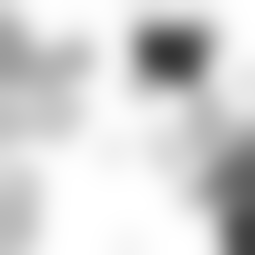

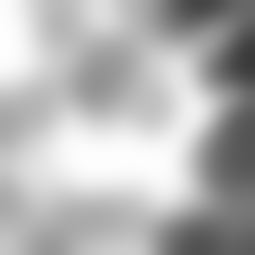

  3%|███████▏                                                                                                                                                                                                                         | 113/3512 [00:12<04:28, 12.66it/s]

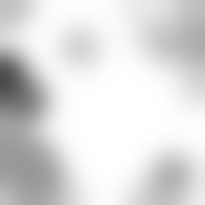

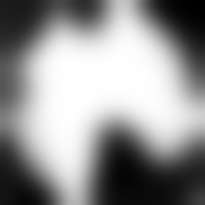

  3%|███████▌                                                                                                                                                                                                                         | 118/3512 [00:13<03:41, 15.32it/s]

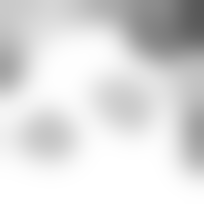

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3512/3512 [02:42<00:00, 21.63it/s]


0.43302


In [6]:
pred = '/nfs/ws1/ryan/CleanCode/Projects/Peekaboo/Experiments/Dreams/untracked/for_xiang/coco_2'
prefix = '/nfs/ws1/datasets/RefCOCO-C/'
gt = '/nfs/ws1/datasets/RefCOCO/label/'

gp3, unfinished3 = eval_peekaboo_coco(prefix, pred, gt)
print(gp3.groupby(['method', 'threshold']).mean().round(5).IoU.max())

In [7]:
pd.set_option('display.max_rows', 500)
# pd.set_option('display.expand_frame_repr', True)

In [8]:
gp3.groupby(['method', 'threshold']).mean().round(5)

IoU
method                         threshold         
Peekaboo-clip_raster_bilateral 0.00       0.32840
                               2.55       0.32844
                               5.10       0.32850
                               7.65       0.32855
                               10.20      0.32862
                               12.75      0.32867
                               15.30      0.32875
                               17.85      0.32880
                               20.40      0.32889
                               22.95      0.32895
                               25.50      0.32905
                               28.05      0.32917
                               30.60      0.32926
                               33.15      0.32940
                               35.70      0.32951
                               38.25      0.32970
                               40.80      0.32982
                               43.35      0.33004
                               45.90      0.33020
                               48.45      0.33046
                               51.00      0.33075
                               53.55      0.33095
                               56.10      0.33127
                               58.65      0.33150
                               61.20      0.33189
                               63.75      0.33217
                               66.30      0.33261
                               68.85      0.33292
                               71.40      0.33338
                               73.95      0.33370
                               76.50      0.33419
                               79.05      0.33468
                               81.60      0.33499
                               84.15      0.33550
                               86.70      0.33587
                               89.25      0.33650
                               91.80      0.33693
                               94.35      0.33761
                               96.90      0.33811
                               99.45      0.33887
                               102.00     0.33959
                               104.55     0.34008
                               107.10     0.34087
                               109.65     0.34143
                               112.20     0.34238
                               114.75     0.34303
                               117.30     0.34402
                               119.85     0.34471
                               122.40     0.34574
                               124.95     0.34645
                               127.50     0.34749
                               130.05     0.34868
                               132.60     0.34948
                               135.15     0.35058
                               137.70     0.35132
                               140.25     0.35243
                               142.80     0.35321
                               145.35     0.35435
                               147.90     0.35516
                               150.45     0.35646
                               153.00     0.35772
                               155.55     0.35858
                               158.10     0.35970
                               160.65     0.36055
                               163.20     0.36184
                               165.75     0.36281
                               168.30     0.36408
                               170.85     0.36486
                               173.40     0.36586
                               175.95     0.36632
                               178.50     0.36693
                               181.05     0.36743
                               183.60     0.36768
                               186.15     0.36807
                               188.70     0.36811
                               191.25     0.36771
                               193.80     0.36731
                               196.35     0.36627
                               198.90     0.36

In [9]:
gp3.to_pickle("./RefCOCO-Peekaboo.pkl")  

# Fix the naming issue

In [10]:
folders = glob('/nfs/ws1/ryan/CleanCode/Projects/Peekaboo/Experiments/Dreams/untracked/for_xiang/coco_2/*')
with open('/nfs/ws1/datasets/RefCOCO-C/cropped.txt', 'r') as f:
    tasks = [i.split()[0] for i in f.readlines()]

for folder in folders:
    method = folder.split('/')[-1]
    sub = 'images' if method == 'preview_images' else 'alpha'
    
    src = os.path.join(folder, sub)
    
    for img in tqdm(glob(src + '/*.jpg')):
        n_img = img.split('/')
        i = 0
        filename = n_img[-1]
        try:
            i = tasks.index(filename)
        except:
            continue
        while tasks[i+1] == filename:
            i += 1
        n_img[-1] = f'{i}-' + n_img[-1] 
        l_img = '/'.join(n_img)
        if os.path.exists(l_img):
            continue
        os.symlink(img, l_img)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 59780.42it/s]
